## Hyperspectral Image Segmentation by Gradient Boosting Classifier 

### standardized spectra at full resolution without spatial dimension

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## GBDT on veg_00108 (South Facing @ ~2pm)

In [8]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [9]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [10]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [11]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)

In [12]:
cube_std_reshaped = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])

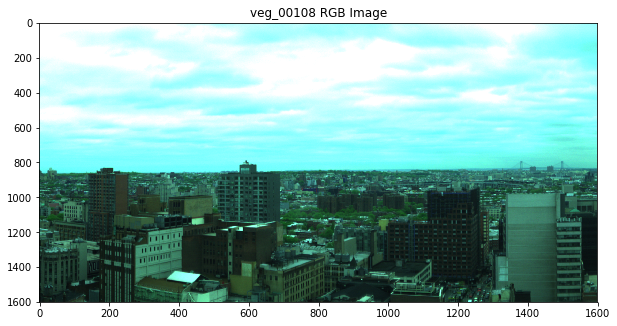

In [13]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

#### Reading manually classified set for training and testing

In [14]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


#### split classified pixels into 80% training and 20% testing sets

In [15]:
import random

# sky coordinates
sky_ind = np.arange(sky_coords.shape[0])
random.Random(3).shuffle(sky_ind)
lim_ind = int(len(sky_ind)*0.8)
sky_train_ind = sky_ind[:lim_ind]
sky_test_ind = sky_ind[lim_ind:]
print("sky %d %d" % (len(sky_train_ind), len(sky_test_ind)))

# clouds coordinates
clouds_ind = np.arange(clouds_coords.shape[0])
random.Random(3).shuffle(clouds_ind)
lim_ind = int(len(clouds_ind)*0.8)
clouds_train_ind = clouds_ind[:lim_ind]
clouds_test_ind = clouds_ind[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind), len(clouds_test_ind)))

# vegetation coordinates
veg_ind = np.arange(veg_coords.shape[0])
random.Random(3).shuffle(veg_ind)
lim_ind = int(len(veg_ind)*0.8)
veg_train_ind = veg_ind[:lim_ind]
veg_test_ind = veg_ind[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind), len(veg_test_ind)))

# water coordinates
wtr_ind = np.arange(wtr_coords.shape[0])
random.Random(3).shuffle(wtr_ind)
lim_ind = int(len(wtr_ind)*0.8)
wtr_train_ind = wtr_ind[:lim_ind]
wtr_test_ind = wtr_ind[lim_ind:]
print("water %d %d" % (len(wtr_train_ind), len(wtr_test_ind)))

# built coordinates
blt_ind = np.arange(blt_coords.shape[0])
random.Random(3).shuffle(blt_ind)
lim_ind = int(len(blt_ind)*0.8)
blt_train_ind = blt_ind[:lim_ind]
blt_test_ind = blt_ind[lim_ind:]
print("built %d %d" % (len(blt_train_ind), len(blt_test_ind)))

# windows coordinates
windows_ind = np.arange(windows_coords.shape[0])
random.Random(3).shuffle(windows_ind)
lim_ind = int(len(windows_ind)*0.8)
windows_train_ind = windows_ind[:lim_ind]
windows_test_ind = windows_ind[lim_ind:]
print("windows %d %d" % (len(windows_train_ind), len(windows_test_ind)))

# roads coordinates
rds_ind = np.arange(rds_coords.shape[0])
random.Random(3).shuffle(rds_ind)
lim_ind = int(len(rds_ind)*0.8)
rds_train_ind = rds_ind[:lim_ind]
rds_test_ind = rds_ind[lim_ind:]
print("roads %d %d" % (len(rds_train_ind), len(rds_test_ind)))

# cars coordinates
cars_ind = np.arange(cars_coords.shape[0])
random.Random(3).shuffle(cars_ind)
lim_ind = int(len(cars_ind)*0.8)
cars_train_ind = cars_ind[:lim_ind]
cars_test_ind = cars_ind[lim_ind:]
print("cars %d %d" % (len(cars_train_ind), len(cars_test_ind)))

# metal coordinates
mtl_ind = np.arange(mtl_coords.shape[0])
random.Random(3).shuffle(mtl_ind)
lim_ind = int(len(mtl_ind)*0.8)
mtl_train_ind = mtl_ind[:lim_ind]
mtl_test_ind = mtl_ind[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind), len(mtl_test_ind)))

sky 240 60
clouds 400 100
vegetation 480 120
water 40 10
built 816 204
windows 400 100
roads 24 6
cars 80 20
metal 80 20


In [16]:
cube_sky_train = cube_std_reshaped[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_reshaped[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_reshaped[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_reshaped[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_reshaped[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_reshaped[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_reshaped[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_reshaped[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_reshaped[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_reshaped[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_reshaped[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
cube_windows_test = cube_std_reshaped[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_reshaped[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_reshaped[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_reshaped[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_reshaped[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_reshaped[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_reshaped[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 848) (60, 848)
clouds  (400, 848) (100, 848)
vegetation  (480, 848) (120, 848)
water  (40, 848) (10, 848)
built  (816, 848) (204, 848)
windows  (400, 848) (100, 848)
roads  (24, 848) (6, 848)
cars  (80, 848) (20, 848)
metal  (80, 848) (20, 848)


In [17]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]

print(cube_train.shape)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]

print(cube_test.shape)

(2560, 848)
(640, 848)


### Train GBC

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
# find best max_depth

mx_dpth = [2,3,5,10,15,20]

import time

for max_depth in mx_dpth:
    start_time = time.time()
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=max_depth, random_state=2)
    gbc.fit(cube_train, cube_train_labels)

    print("Max Depth: ", max_depth)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(cube_train, cube_train_labels)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(cube_test, cube_test_labels)))
    
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Max Depth:  2
Accuracy score (training): 0.998
Accuracy score (testing): 0.917
00:01:39
Max Depth:  3
Accuracy score (training): 1.000
Accuracy score (testing): 0.919
00:02:24
Max Depth:  5
Accuracy score (training): 1.000
Accuracy score (testing): 0.927
00:03:31
Max Depth:  10
Accuracy score (training): 1.000
Accuracy score (testing): 0.903
00:03:03
Max Depth:  15
Accuracy score (training): 1.000
Accuracy score (testing): 0.902
00:03:02
Max Depth:  20
Accuracy score (training): 1.000
Accuracy score (testing): 0.894
00:02:55


In [20]:
# find best learning rate

lrn_rt = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

import time

for learning_rate in lrn_rt:
    start_time = time.time()
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=5, random_state=2)
    gbc.fit(cube_train, cube_train_labels)

    print("Learning Rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(cube_train, cube_train_labels)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(cube_test, cube_test_labels)))
    
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Learning Rate:  0.05
Accuracy score (training): 1.000
Accuracy score (testing): 0.916
00:04:44
Learning Rate:  0.1
Accuracy score (training): 1.000
Accuracy score (testing): 0.927
00:03:26
Learning Rate:  0.25
Accuracy score (training): 1.000
Accuracy score (testing): 0.925
00:01:28
Learning Rate:  0.5
Accuracy score (training): 1.000
Accuracy score (testing): 0.920
00:00:47
Learning Rate:  0.75
Accuracy score (training): 1.000
Accuracy score (testing): 0.900
00:00:35
Learning Rate:  1.0
Accuracy score (training): 1.000
Accuracy score (testing): 0.898
00:00:30


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2)

In [23]:
import time
start_time = time.time()

GBCmodel = gbc.fit(cube_train, cube_train_labels)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:03:28


In [24]:
# classify entire binned cube
import time
start_time = time.time()

predictCube = GBCmodel.predict(cube_standard)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:03:14


In [25]:
predictCube_reshape = predictCube.reshape(cube_std_reshaped.shape[0], cube_std_reshaped.shape[1])

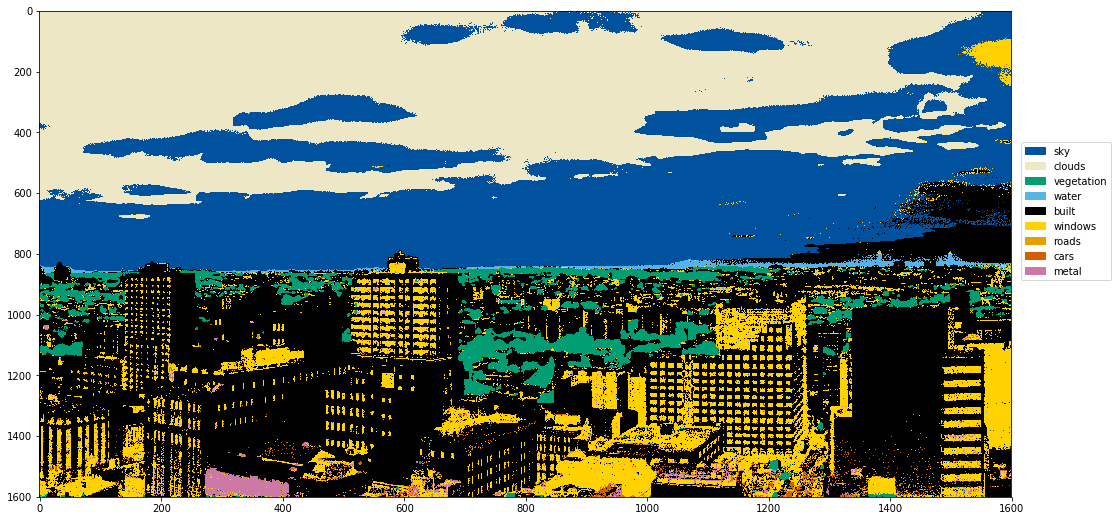

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/GBDT_wo_spatial_train_108_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

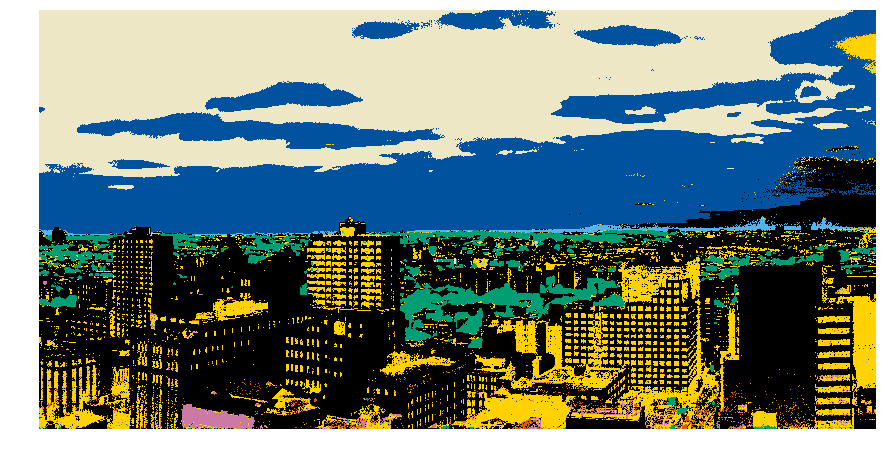

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/GBDT_train_108_test_108_predict_map.png", bbox_inches='tight')

In [28]:
import pickle
pickle.dump(predictCube_reshape, open("./plots/GBDT_train_108_test_108_predict_map.pickle", "wb"))

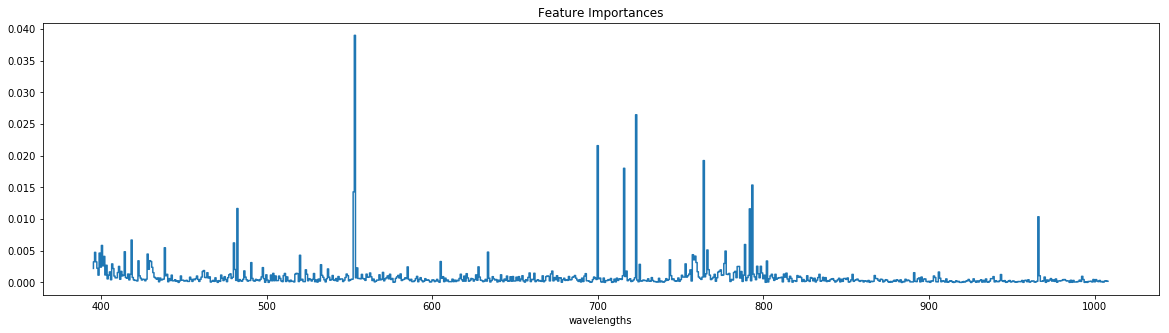

<Figure size 432x288 with 0 Axes>

In [30]:
# feature importances

importances = GBCmodel.feature_importances_
wavelengths = cube.waves
notzero = np.where(importances > 0)
plt.figure(figsize = (20,5))
plt.step(wavelengths, importances)
plt.title("Feature Importances")
plt.xlabel("wavelengths")
plt.show()
plt.savefig("./plots/GBDT_train_108_test_108_feature_importances.png")

In [31]:
import pickle
pickle.dump(importances, open("./plots/GBDT_train_108_test_108_feature_importances.pickle", "wb"))

### Evaluation Metrics (veg_00108)

In [32]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [33]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [34]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [35]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0   9   1   0   0   0   0]
 [  0   0   0   0 197   7   0   0   0]
 [  0   0   0   0  11  88   0   1   0]
 [  0   0   0   0   0   1   4   0   1]
 [  0   0   0   0   5   3   0  12   0]
 [  0   0   0   0  12   2   0   1   5]]

Accuracy Score
0.9265625

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      0.90      0.95        10
      built       0.86      0.97      0.91       204
    windows       0.87      0.88      0.88       100
      roads       1.00      0.67      0.80         6
       cars       0.86      0.60      0.71        20
      metal       0.83      0.25      0.38        20

avg / total       0.93      0.93      0.92       6

In [36]:
f = open("./metrics/GBDT_train_108_test_108_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

---
## GBDT on veg_00000 (South Facing @ ~6pm)

In [37]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [38]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [39]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


In [40]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)

In [41]:
cube_std_reshaped0 = cube_standard0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])

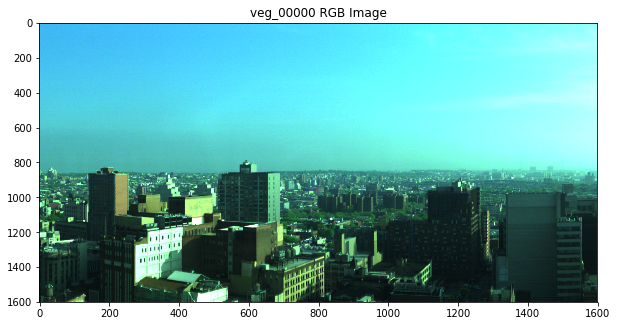

In [42]:
cube_norm0 = (cube_reshaped0 - cube_reshaped0.min()) / (cube_reshaped0.max() - cube_reshaped0.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind0 = (np.abs(cube0.waves - 650.0)).argmin()
green_ind0 = (np.abs(cube0.waves - 550.0)).argmin()
blue_ind0 = (np.abs(cube0.waves - 450.0)).argmin()

cube_reshaped02 = cube_norm0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
cube_scene0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 RGB Image')
ax.imshow(cube_scene0, aspect=0.5)
plt.show()

### Reading manually classified set for training and testing

In [43]:
# read manually selected coordinates files

#sky coordinates
sky_file0 = open("../manual_classified_pixels/1_sky_coordinates_000.txt", "r")
sky_coords0 = sky_file0.readlines()
sky_file0.close()
sky_coords0 = np.array([point_from_string(line) for line in sky_coords0])
print("sky:        ", sky_coords0.shape)

#clouds coordinates
clouds_file0 = open("../manual_classified_pixels/2_clouds_coordinates_000.txt", "r")
clouds_coords0 = clouds_file0.readlines()
clouds_file0.close()
clouds_coords0 = np.array([point_from_string(line) for line in clouds_coords0])
print("clouds:     ", clouds_coords0.shape)

#vegetation coordinates
veg_file0 = open("../manual_classified_pixels/3_vegetation_coordinates_000.txt", "r")
veg_coords0 = veg_file0.readlines()
veg_file0.close()
veg_coords0 = np.array([point_from_string(line) for line in veg_coords0])
print("vegetation: ", veg_coords0.shape)

#water coordinates
wtr_file0 = open("../manual_classified_pixels/4_water_coordinates_000.txt", "r")
wtr_coords0 = wtr_file0.readlines()
wtr_file0.close()
wtr_coords0 = np.array([point_from_string(line) for line in wtr_coords0])
print("water:      ", wtr_coords0.shape)

#buildings coordinates
blt_file0 = open("../manual_classified_pixels/5_buildings_coordinates_000.txt", "r")
blt_coords0 = blt_file0.readlines()
blt_file0.close()
blt_coords0 = np.array([point_from_string(line) for line in blt_coords0])
print("buildings:  ", blt_coords0.shape)

#windows coordinates
windows_file0 = open("../manual_classified_pixels/6_windows_coordinates_000.txt", "r")
windows_coords0 = windows_file0.readlines()
windows_file0.close()
windows_coords0 = np.array([point_from_string(line) for line in windows_coords0])
print("windows:    ", windows_coords0.shape)

#roads coordinates
rds_file0 = open("../manual_classified_pixels/7_roads_coordinates_000.txt", "r")
rds_coords0 = rds_file0.readlines()
rds_file0.close()
rds_coords0 = np.array([point_from_string(line) for line in rds_coords0])
print("road:       ", rds_coords0.shape)

#cars coordinates
cars_file0 = open("../manual_classified_pixels/8_cars_coordinates_000.txt", "r")
cars_coords0 = cars_file0.readlines()
cars_file0.close()
cars_coords0 = np.array([point_from_string(line) for line in cars_coords0])
print("cars:       ", cars_coords0.shape)

#metal coordinates
mtl_file0 = open("../manual_classified_pixels/9_metal_coordinates_000.txt", "r")
mtl_coords0 = mtl_file0.readlines()
mtl_file0.close()
mtl_coords0 = np.array([point_from_string(line) for line in mtl_coords0])
print("metal:      ", mtl_coords0.shape)

sky:         (400, 2)
clouds:      (500, 2)
vegetation:  (610, 2)
water:       (0,)
buildings:   (1200, 2)
windows:     (500, 2)
road:        (60, 2)
cars:        (55, 2)
metal:       (230, 2)


### split classified pixels into 80% training and 20% testing

In [44]:
import random

# sky coordinates
sky_ind0 = np.arange(sky_coords0.shape[0])
random.Random(3).shuffle(sky_ind0)
lim_ind = int(len(sky_ind0)*0.8)
sky_train_ind0 = sky_ind0[:lim_ind]
sky_test_ind0 = sky_ind0[lim_ind:]
print("sky %d %d" % (len(sky_train_ind0), len(sky_test_ind0)))

# clouds coordinates
clouds_ind0 = np.arange(clouds_coords0.shape[0])
random.Random(3).shuffle(clouds_ind0)
lim_ind = int(len(clouds_ind0)*0.8)
clouds_train_ind0 = clouds_ind0[:lim_ind]
clouds_test_ind0 = clouds_ind0[lim_ind:]
print("clouds %d %d" % (len(clouds_train_ind0), len(clouds_test_ind0)))

# vegetation coordinates
veg_ind0 = np.arange(veg_coords0.shape[0])
random.Random(3).shuffle(veg_ind0)
lim_ind = int(len(veg_ind0)*0.8)
veg_train_ind0 = veg_ind0[:lim_ind]
veg_test_ind0 = veg_ind0[lim_ind:]
print("vegetation %d %d" % (len(veg_train_ind0), len(veg_test_ind0)))

# water coordinates
#wtr_ind0 = np.arange(wtr_coords0.shape[0])
#random.Random(3).shuffle(wtr_ind0)
#lim_ind = int(len(wtr_ind0)*0.8)
#wtr_train_ind0 = wtr_ind[:lim_ind]
#wtr_test_ind0 = wtr_ind[lim_ind:]
#print("water %d %d" % (len(wtr_train_ind0), len(wtr_test_ind0)))

# built coordinates
blt_ind0 = np.arange(blt_coords0.shape[0])
random.Random(3).shuffle(blt_ind0)
lim_ind = int(len(blt_ind0)*0.8)
blt_train_ind0 = blt_ind0[:lim_ind]
blt_test_ind0 = blt_ind0[lim_ind:]
print("built %d %d" % (len(blt_train_ind0), len(blt_test_ind0)))

# windows coordinates
windows_ind0 = np.arange(windows_coords0.shape[0])
random.Random(3).shuffle(windows_ind0)
lim_ind = int(len(windows_ind0)*0.8)
windows_train_ind0 = windows_ind0[:lim_ind]
windows_test_ind0 = windows_ind0[lim_ind:]
print("windows %d %d" % (len(windows_train_ind0), len(windows_test_ind0)))

# roads coordinates
rds_ind0 = np.arange(rds_coords0.shape[0])
random.Random(3).shuffle(rds_ind0)
lim_ind = int(len(rds_ind0)*0.8)
rds_train_ind0 = rds_ind0[:lim_ind]
rds_test_ind0 = rds_ind0[lim_ind:]
print("roads %d %d" % (len(rds_train_ind0), len(rds_test_ind0)))

# cars coordinates
cars_ind0 = np.arange(cars_coords0.shape[0])
random.Random(3).shuffle(cars_ind0)
lim_ind = int(len(cars_ind0)*0.8)
cars_train_ind0 = cars_ind0[:lim_ind]
cars_test_ind0 = cars_ind0[lim_ind:]
print("cars %d %d" % (len(cars_train_ind0), len(cars_test_ind0)))

# metal coordinates
mtl_ind0 = np.arange(mtl_coords0.shape[0])
random.Random(3).shuffle(mtl_ind0)
lim_ind = int(len(mtl_ind0)*0.8)
mtl_train_ind0 = mtl_ind0[:lim_ind]
mtl_test_ind0 = mtl_ind0[lim_ind:]
print("metal %d %d" % (len(mtl_train_ind0), len(mtl_test_ind0)))

sky 320 80
clouds 400 100
vegetation 488 122
built 960 240
windows 400 100
roads 48 12
cars 44 11
metal 184 46


In [45]:
cube_sky_train0 = cube_std_reshaped0[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
cube_sky_test0 = cube_std_reshaped0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
print("sky ", cube_sky_train0.shape, cube_sky_test0.shape)

cube_clouds_train0 = cube_std_reshaped0[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
cube_clouds_test0 = cube_std_reshaped0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
print("clouds ", cube_clouds_train0.shape, cube_clouds_test0.shape)

cube_veg_train0 = cube_std_reshaped0[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
cube_veg_test0 = cube_std_reshaped0[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
print("vegetation ", cube_veg_train0.shape, cube_veg_test0.shape)

#cube_wtr_train0 = cube_std_reshaped0[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#cube_wtr_test0 = cube_std_reshaped0[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#print("water ", cube_wtr_train0.shape, cube_wtr_test0.shape)

cube_blt_train0 = cube_std_reshaped0[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
cube_blt_test0 = cube_std_reshaped0[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
print("built ", cube_blt_train0.shape, cube_blt_test0.shape)

cube_windows_train0 = cube_std_reshaped0[windows_coords0[windows_train_ind0[:], 0], windows_coords0[windows_train_ind0[:], 1], :]
cube_windows_test0 = cube_std_reshaped0[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
print("windows ", cube_windows_train0.shape, cube_windows_test0.shape)

cube_rds_train0 = cube_std_reshaped0[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
cube_rds_test0 = cube_std_reshaped0[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
print("roads ", cube_rds_train0.shape, cube_rds_test0.shape)

cube_cars_train0 = cube_std_reshaped0[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cube_cars_test0 = cube_std_reshaped0[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
print("cars ", cube_cars_train0.shape, cube_cars_test0.shape)

cube_mtl_train0 = cube_std_reshaped0[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
cube_mtl_test0 = cube_std_reshaped0[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
print("metal ", cube_mtl_train0.shape, cube_mtl_test0.shape)

sky  (320, 848) (80, 848)
clouds  (400, 848) (100, 848)
vegetation  (488, 848) (122, 848)
built  (960, 848) (240, 848)
windows  (400, 848) (100, 848)
roads  (48, 848) (12, 848)
cars  (44, 848) (11, 848)
metal  (184, 848) (46, 848)


In [46]:
# concatenate training and testing sets and create index arrays

cube_train0 = np.concatenate((cube_sky_train0, cube_clouds_train0, cube_veg_train0, cube_blt_train0,
                            cube_windows_train0, cube_rds_train0, cube_cars_train0, cube_mtl_train0), axis=0)
cube_train_labels0 = [0]*cube_sky_train0.shape[0] + [1]*cube_clouds_train0.shape[0] \
                    + [2]*cube_veg_train0.shape[0] + [4]*cube_blt_train0.shape[0] \
                    + [5]*cube_windows_train0.shape[0] + [6]*cube_rds_train0.shape[0] \
                    + [7]*cube_cars_train0.shape[0] + [8]*cube_mtl_train0.shape[0]

print(cube_train0.shape)

cube_test0 = np.concatenate((cube_sky_test0, cube_clouds_test0, cube_veg_test0, cube_blt_test0,
                            cube_windows_test0, cube_rds_test0, cube_cars_test0, cube_mtl_test0), axis=0)
cube_test_labels0 = [0]*cube_sky_test0.shape[0] + [1]*cube_clouds_test0.shape[0] \
                    + [2]*cube_veg_test0.shape[0] + [4]*cube_blt_test0.shape[0] \
                    + [5]*cube_windows_test0.shape[0] + [6]*cube_rds_test0.shape[0] \
                    + [7]*cube_cars_test0.shape[0] + [8]*cube_mtl_test0.shape[0]

print(cube_test0.shape)

(2844, 848)
(711, 848)


## Train GBC

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# find best max_depth

mx_dpth = [2,3,5,10,15,20]

import time

for max_depth in mx_dpth:
    start_time = time.time()
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=max_depth, random_state=4)
    gbc.fit(cube_train0, cube_train_labels0)

    print("Max Depth: ", max_depth)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(cube_train0, cube_train_labels0)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(cube_test0, cube_test_labels0)))
    
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Max Depth:  2
Accuracy score (training): 0.984
Accuracy score (testing): 0.890
00:01:59
Max Depth:  3
Accuracy score (training): 1.000
Accuracy score (testing): 0.897
00:02:56
Max Depth:  5
Accuracy score (training): 1.000
Accuracy score (testing): 0.904
00:04:29
Max Depth:  10
Accuracy score (training): 1.000
Accuracy score (testing): 0.887
00:05:01
Max Depth:  15
Accuracy score (training): 1.000
Accuracy score (testing): 0.859
00:04:52


In [ ]:
# find best learning rate

lrn_rt = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

import time

for learning_rate in lrn_rt:
    start_time = time.time()
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=5, random_state=4)
    gbc.fit(cube_train0, cube_train_labels0)

    print("Learning Rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(cube_train0, cube_train_labels0)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(cube_test0, cube_test_labels0)))
    
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=4)

In [ ]:
import time
start_time = time.time()

GBCmodel = gbc.fit(cube_train0, cube_train_labels0)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
import time
start_time = time.time()

predictCube0 = GBCmodel.predict(cube_standard0)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/GBDT_wo_spatial_train_108_4_000_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/GBDT_train_000_test_000_predict_map.png", bbox_inches='tight')

In [ ]:
import pickle
pickle.dump(predictCube_reshape0, open("./plots/GBDT_train_000_test_000_predict_map.pickle", "wb"))

In [ ]:
# feature importances

importances = GBCmodel.feature_importances_
wavelengths = cube0.waves
notzero = np.where(importances > 0)
plt.figure(figsize = (20,5))
plt.step(wavelengths, importances)
plt.title("Feature Importances")
plt.xlabel("wavelengths")
plt.show()
f.savefig("./plots/GBDT_train_000_test_000_feature_importances.png")

In [ ]:
import pickle
pickle.dump(predictCube_reshape0, open("./plots/GBDT_train_000_test_000_feature_importances.pickle", "wb"))

### Evaluation Metrics (veg_00000)

In [ ]:
wtr_coords0=np.array([[0,0]])

In [ ]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[:,0], sky_coords0[:,1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[:,0], clouds_coords0[:,1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[:,0], veg_coords0[:,1]]
#labels0_pred_wtr = predictCube_reshape0[wtr_coords0[:,0], wtr_coords0[:,1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[:,0], blt_coords0[:,1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[:,0], windows_coords0[:,1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[:,0], rds_coords0[:,1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[:,0], cars_coords0[:,1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[:,0], mtl_coords0[:,1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, labels0_pred_cars, labels0_pred_mtl))

In [ ]:
labels0_true_sky = np.full((sky_coords0.shape[0]), 0)
labels0_true_clouds = np.full((clouds_coords0.shape[0]), 1)
labels0_true_veg = np.full((veg_coords0.shape[0]), 2)
#labels0_true_wtr = np.full((wtr_coords0.shape[0]), 3)
labels0_true_blt = np.full((blt_coords0.shape[0]), 4)
labels0_true_windows = np.full((windows_coords0.shape[0]), 5)
labels0_true_rds = np.full((rds_coords0.shape[0]), 6)
labels0_true_cars = np.full((cars_coords0.shape[0]), 7)
labels0_true_mtl = np.full((mtl_coords0.shape[0]), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [ ]:
print(labels0_pred.shape)
print(labels0_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

In [ ]:
f = open("./metrics/GBDT_train_000_test_000_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

---
## GBDT on North Facing Image

In [ ]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

In [ ]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

In [ ]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

In [ ]:
cube_norm_north = (cube_reshaped_north - cube_reshaped_north.min()) / (cube_reshaped_north.max() - cube_reshaped_north.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind_n = (np.abs(cube_north.waves - 650.0)).argmin()
green_ind_n = (np.abs(cube_north.waves - 550.0)).argmin()
blue_ind_n = (np.abs(cube_north.waves - 450.0)).argmin()

cube_reshaped_north2 = cube_norm_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
cube_scene_north = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing RGB Image')
ax.imshow(cube_scene_north, aspect=0.4)
plt.show()

In [ ]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
cube_reshaped_north = cube_standard_north

In [ ]:
print(len(cube.waves))
print(min(cube.waves), max(cube.waves))
print()
print(len(cube_north.waves))
print(min(cube_north.waves), max(cube_north.waves))

In [ ]:
# interpolating an extrapolating the north facing scene

from scipy.interpolate import interp1d

interp_hsi = interp1d(cube_north.waves, cube_reshaped_north, axis=1, fill_value="extrapolate")
northri = interp_hsi(cube.waves)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cube_north.waves, cube_reshaped_north[1000, :], ".", color="r")
ax.plot(cube.waves, northri[1000, :], 'o', ms=3, color="b")
ax.plot(cube_north.waves, cube_reshaped_north[1000, :], ".", ms=3, color="y")

In [ ]:
print(cube_standard_north.shape)
print(northri.shape)
cube_standard_north = northri
print(cube_standard_north.shape)

In [ ]:
cube_std_reshapedn = cube_standard_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub.shape[0])

### Reading manually classified set for training and testing

In [ ]:
# read manually selected coordinates files

#sky coordinates
sky_filen = open("../manual_classified_pixels/1_sky_coordinates_north.txt", "r")
sky_coordsn = sky_filen.readlines()
sky_filen.close()
sky_coordsn = np.array([point_from_string(line) for line in sky_coordsn])
print("sky:        ", sky_coordsn.shape)

#clouds coordinates
clouds_filen = open("../manual_classified_pixels/2_clouds_coordinates_north.txt", "r")
clouds_coordsn = clouds_filen.readlines()
clouds_filen.close()
clouds_coordsn = np.array([point_from_string(line) for line in clouds_coordsn])
print("clouds:     ", clouds_coordsn.shape)

#vegetation coordinates
veg_filen = open("../manual_classified_pixels/3_vegetation_coordinates_north.txt", "r")
veg_coordsn = veg_filen.readlines()
veg_filen.close()
veg_coordsn = np.array([point_from_string(line) for line in veg_coordsn])
print("vegetation: ", veg_coordsn.shape)

#water coordinates
wtr_filen = open("../manual_classified_pixels/4_water_coordinates_north.txt", "r")
wtr_coordsn = wtr_filen.readlines()
wtr_filen.close()
wtr_coordsn = np.array([point_from_string(line) for line in wtr_coordsn])
print("water:      ", wtr_coordsn.shape)

#buildings coordinates
blt_filen = open("../manual_classified_pixels/5_buildings_coordinates_north.txt", "r")
blt_coordsn = blt_filen.readlines()
blt_filen.close()
blt_coordsn = np.array([point_from_string(line) for line in blt_coordsn])
print("buildings:  ", blt_coordsn.shape)

#windows coordinates
windows_filen = open("../manual_classified_pixels/6_windows_coordinates_north.txt", "r")
windows_coordsn = windows_filen.readlines()
windows_filen.close()
windows_coordsn = np.array([point_from_string(line) for line in windows_coordsn])
print("windows:    ", windows_coordsn.shape)

#roads coordinates
rds_filen = open("../manual_classified_pixels/7_roads_coordinates_north.txt", "r")
rds_coordsn = rds_filen.readlines()
rds_filen.close()
rds_coordsn = np.array([point_from_string(line) for line in rds_coordsn])
print("road:       ", rds_coordsn.shape)

#cars coordinates
cars_filen = open("../manual_classified_pixels/8_cars_coordinates_north.txt", "r")
cars_coordsn = cars_filen.readlines()
cars_filen.close()
cars_coordsn = np.array([point_from_string(line) for line in cars_coordsn])
print("cars:       ", cars_coordsn.shape)

#metal coordinates
mtl_filen = open("../manual_classified_pixels/9_metal_coordinates_north.txt", "r")
mtl_coordsn = mtl_filen.readlines()
mtl_filen.close()
mtl_coordsn = np.array([point_from_string(line) for line in mtl_coordsn])
print("metal:      ", mtl_coordsn.shape)

### split classified pixels into 80% training and 20% testing

In [ ]:
import random

# sky coordinates
sky_indn = np.arange(sky_coordsn.shape[0])
random.Random(3).shuffle(sky_indn)
lim_ind = int(len(sky_indn)*0.8)
sky_train_indn = sky_indn[:lim_ind]
sky_test_indn = sky_indn[lim_ind:]
print("sky %d %d" % (len(sky_train_indn), len(sky_test_indn)))

# clouds coordinates
clouds_indn = np.arange(clouds_coordsn.shape[0])
random.Random(3).shuffle(clouds_indn)
lim_ind = int(len(clouds_indn)*0.8)
clouds_train_indn = clouds_indn[:lim_ind]
clouds_test_indn = clouds_indn[lim_ind:]
print("clouds %d %d" % (len(clouds_train_indn), len(clouds_test_indn)))

# vegetation coordinates
veg_indn = np.arange(veg_coordsn.shape[0])
random.Random(3).shuffle(veg_indn)
lim_ind = int(len(veg_indn)*0.8)
veg_train_indn = veg_indn[:lim_ind]
veg_test_indn = veg_indn[lim_ind:]
print("vegetation %d %d" % (len(veg_train_indn), len(veg_test_indn)))

# water coordinates
wtr_indn = np.arange(wtr_coordsn.shape[0])
random.Random(3).shuffle(wtr_indn)
lim_ind = int(len(wtr_indn)*0.8)
wtr_train_indn = wtr_indn[:lim_ind]
wtr_test_indn = wtr_indn[lim_ind:]
print("water %d %d" % (len(wtr_train_indn), len(wtr_test_indn)))

# built coordinates
blt_indn = np.arange(blt_coordsn.shape[0])
random.Random(3).shuffle(blt_indn)
lim_ind = int(len(blt_indn)*0.8)
blt_train_indn = blt_indn[:lim_ind]
blt_test_indn = blt_indn[lim_ind:]
print("built %d %d" % (len(blt_train_indn), len(blt_test_indn)))

# windows coordinates
windows_indn = np.arange(windows_coordsn.shape[0])
random.Random(3).shuffle(windows_indn)
lim_ind = int(len(windows_indn)*0.8)
windows_train_indn = windows_indn[:lim_ind]
windows_test_indn = windows_indn[lim_ind:]
print("windows %d %d" % (len(windows_train_indn), len(windows_test_indn)))

# roads coordinates
rds_indn = np.arange(rds_coordsn.shape[0])
random.Random(3).shuffle(rds_indn)
lim_ind = int(len(rds_indn)*0.8)
rds_train_indn = rds_indn[:lim_ind]
rds_test_indn = rds_indn[lim_ind:]
print("roads %d %d" % (len(rds_train_indn), len(rds_test_indn)))

# cars coordinates
cars_indn = np.arange(cars_coordsn.shape[0])
random.Random(3).shuffle(cars_indn)
lim_ind = int(len(cars_indn)*0.8)
cars_train_indn = cars_indn[:lim_ind]
cars_test_indn = cars_indn[lim_ind:]
print("cars %d %d" % (len(cars_train_indn), len(cars_test_indn)))

# metal coordinates
mtl_indn = np.arange(mtl_coordsn.shape[0])
random.Random(3).shuffle(mtl_indn)
lim_ind = int(len(mtl_indn)*0.8)
mtl_train_indn = mtl_indn[:lim_ind]
mtl_test_indn = mtl_indn[lim_ind:]
print("metal %d %d" % (len(mtl_train_indn), len(mtl_test_indn)))

In [ ]:
cube_sky_trainn = cube_std_reshapedn[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
cube_sky_testn = cube_std_reshapedn[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
print("sky ", cube_sky_trainn.shape, cube_sky_testn.shape)

cube_clouds_trainn = cube_std_reshapedn[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
cube_clouds_testn = cube_std_reshapedn[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
print("clouds ", cube_clouds_trainn.shape, cube_clouds_testn.shape)

cube_veg_trainn = cube_std_reshapedn[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
cube_veg_testn = cube_std_reshapedn[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
print("vegetation ", cube_veg_trainn.shape, cube_veg_testn.shape)

cube_wtr_trainn = cube_std_reshapedn[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
cube_wtr_testn = cube_std_reshapedn[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
print("water ", cube_wtr_trainn.shape, cube_wtr_testn.shape)

cube_blt_trainn = cube_std_reshapedn[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
cube_blt_testn = cube_std_reshapedn[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
print("built ", cube_blt_trainn.shape, cube_blt_testn.shape)

cube_windows_trainn = cube_std_reshapedn[windows_coordsn[windows_train_indn[:], 0], windows_coordsn[windows_train_indn[:], 1], :]
cube_windows_testn = cube_std_reshapedn[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
print("windows ", cube_windows_trainn.shape, cube_windows_testn.shape)

cube_rds_trainn = cube_std_reshapedn[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
cube_rds_testn = cube_std_reshapedn[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
print("roads ", cube_rds_trainn.shape, cube_rds_testn.shape)

cube_cars_trainn = cube_std_reshapedn[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cube_cars_testn = cube_std_reshapedn[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
print("cars ", cube_cars_trainn.shape, cube_cars_testn.shape)

cube_mtl_trainn = cube_std_reshapedn[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
cube_mtl_testn = cube_std_reshapedn[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
print("metal ", cube_mtl_trainn.shape, cube_mtl_testn.shape)

In [ ]:
# concatenate training and testing sets and create index arrays

cube_trainn = np.concatenate((cube_sky_trainn, cube_clouds_trainn, cube_veg_trainn, cube_wtr_trainn, cube_blt_trainn, 
                            cube_windows_trainn, cube_rds_trainn, cube_cars_trainn, cube_mtl_trainn), axis=0)
cube_train_labelsn = [0]*cube_sky_trainn.shape[0] + [1]*cube_clouds_trainn.shape[0] \
                    + [2]*cube_veg_trainn.shape[0] + [3]*cube_wtr_trainn.shape[0] + [4]*cube_blt_trainn.shape[0] \
                    + [5]*cube_windows_trainn.shape[0] + [6]*cube_rds_trainn.shape[0] \
                    + [7]*cube_cars_trainn.shape[0] + [8]*cube_mtl_trainn.shape[0]

print(cube_trainn.shape)

cube_testn = np.concatenate((cube_sky_testn, cube_clouds_testn, cube_veg_testn, cube_wtr_testn, cube_blt_testn, 
                            cube_windows_testn, cube_rds_testn, cube_cars_testn, cube_mtl_testn), axis=0)
cube_test_labelsn = [0]*cube_sky_testn.shape[0] + [1]*cube_clouds_testn.shape[0] \
                    + [2]*cube_veg_testn.shape[0] + [3]*cube_wtr_testn.shape[0] + [4]*cube_blt_testn.shape[0] \
                    + [5]*cube_windows_testn.shape[0] + [6]*cube_rds_testn.shape[0] \
                    + [7]*cube_cars_testn.shape[0] + [8]*cube_mtl_testn.shape[0]

print(cube_testn.shape)

### Train GBDT

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# find best max_depth

mx_dpth = [2,3,5,10,15,20]

import time

for max_depth in mx_dpth:
    start_time = time.time()
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=max_depth, random_state=2)
    gbc.fit(cube_trainn, cube_train_labelsn)

    print("Max Depth: ", max_depth)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(cube_trainn, cube_train_labelsn)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(cube_testn, cube_test_labelsn)))
    
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
# find best learning rate

lrn_rt = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

import time

for learning_rate in lrn_rt:
    start_time = time.time()
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=5, random_state=2)
    gbc.fit(cube_trainn, cube_train_labelsn)

    print("Learning Rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(cube_trainn, cube_train_labelsn)))
    print("Accuracy score (testing): {0:.3f}".format(gbc.score(cube_testn, cube_test_labelsn)))
    
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=2)

In [ ]:
import time
start_time = time.time()

GBCmodel = gbc.fit(cube_trainn, cube_train_labelsn)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
import time
start_time = time.time()

predictCuben = GBCmodel.predict(cube_standard_north)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/GBDT_wo_spatial_train_108_6_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.4)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/GBDT_train_north_test_north_predict_map.png", bbox_inches='tight')

In [ ]:
import pickle
pickle.dump(predictCube_reshapen, open("./plots/GBDT_train_north_test_north_predict_map.pickle", "wb"))

In [ ]:
# feature importances

importances = GBCmodel.feature_importances_
wavelengths = cube.waves
notzero = np.where(importances > 0)
plt.figure(figsize = (20,5))
plt.step(wavelengths, importances)
plt.title("Feature Importances")
plt.xlabel("wavelengths")
plt.show()
f.savefig("./plots/GBDT_train_north_test_north_feature_importances.png")

In [ ]:
import pickle
pickle.dump(predictCube_reshapen, open("./plots/GBDT_train_north_test_north_feature_importances.pickle", "wb"))

### Evaluation Metrics (north facing)

In [ ]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[:,0], sky_coordsn[:,1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[:,0], clouds_coordsn[:,1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[:,0], veg_coordsn[:,1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[:,0], wtr_coordsn[:,1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[:,0], blt_coordsn[:,1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[:,0], windows_coordsn[:,1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[:,0], rds_coordsn[:,1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[:,0], cars_coordsn[:,1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[:,0], mtl_coordsn[:,1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [ ]:
labelsn_true_sky = np.full((sky_coordsn.shape[0]), 0)
labelsn_true_clouds = np.full((clouds_coordsn.shape[0]), 1)
labelsn_true_veg = np.full((veg_coordsn.shape[0]), 2)
labelsn_true_wtr = np.full((wtr_coordsn.shape[0]), 3)
labelsn_true_blt = np.full((blt_coordsn.shape[0]), 4)
labelsn_true_windows = np.full((windows_coordsn.shape[0]), 5)
labelsn_true_rds = np.full((rds_coordsn.shape[0]), 6)
labelsn_true_cars = np.full((cars_coordsn.shape[0]), 7)
labelsn_true_mtl = np.full((mtl_coordsn.shape[0]), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [ ]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

In [ ]:
f = open("./metrics/GBDT_train_north_test_north_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()